<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module4/M4_2/1_Covering_Firehouse_dw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integer Programming: Fire Station Problem (extracted from the textbook)


Related Readings:
* `Powell`: Chapter 11 (Integer Optimization)
* https://en.wikipedia.org/wiki/Set_cover_problem


# Problem Description

* Locate fire stations so that each district has a fire station in it, or next to it
* Minimize the number of fire stations needed
* Map of districts:

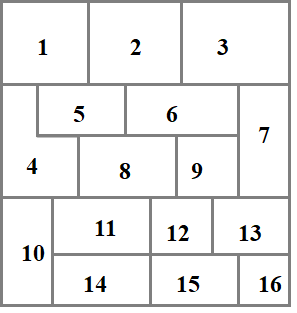

## Setup Your Environment/Imports

In [ ]:
# before you do anything...
# mount your drive!
# click folder on the left...
# import modules

%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *

     |████████████████████████████████| 9.4MB 2.6MB/s 
     |████████████████████████████████| 256kB 34.9MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 163kB 45.8MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coi

## Example of solution 

* The solution below uses 5 fire stations
* The fire station located in District 2 covers the demand of Districts 1, 2, 3, 5, and 6
* Districts 5 and 6 are covered by the fire stations located in Districts 2 and 8; this is OK, you need **at least one**, does not have to be exactly one
* In total, there are $2^{16} = 65536$ possibilities; you can try to use a brute-force algorithm to solve it (but it will probably take some time to run :-) ).

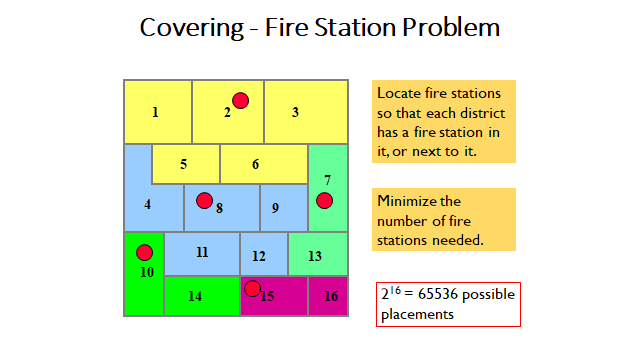

**Define the Objective Function**

$Max(Z) = \sum\limits_{i = 1}^{16}x_i$ `(objective function)`

**Write the Constraints**

subject to:
* $x_1 + x_2 + x_4 + x_5 \geq 1$       `(Site 1)`
* $x_1 + x_2 + x_3 + x_5 + x_6 \geq 1$ `(Site 2)`
* $x_2 + x_3 + x_6 + x_7 \geq 1$  `(Site 3)`
* $x_1 + x_4 + x_5 + x_8 + x_{10} + x_{11} \geq 1$ `(Site 4)`
* $x_1 + x_2 + x_4 + x_5 + x_6 + x_8 \geq 1$ `(Site 5)`
* $x_2 + x_3 + x_5 + x_6 + x_7 + x_8 + x_9 \geq 1$ `(Site 6)`
* $x_3 + x_6 + x_7 + x_9 + x_{13} \geq 1$ `(Site 7)`
* $x_4 + x_5 + x_6 + x_8 + x_9 + x_{11} + x_{12} \geq 1$ `(Site 8)`
* $x_6 + x_7 + x_8 + x_9 + x_{12} + x_{13} \geq 1$ `(Site 9)`
* $x_4 + x_{10} + x_{11} + x_{14} \geq 1$ `(Site 10)`
* $x_4 + x_8 + x_{10} + x_{11} + x_{12} + x_{14} \geq 1$ `(Site 11)`
* $x_8 + x_9 + x_{11} + x_{12} + x_{13} + x_{15} \geq 1$ `(Site 12)`
* $x_7 + x_9 + x_{12} + x_{13} + x_{15} + x_{16} \geq 1$ `(Site 13)`
* $x_{10} + x_{11} + x_{14} + x_{15} \geq 1$ `(Site 14)`
* $x_{12} + x_{13} + x_{14} + x_{15} + x_{16} \geq 1$ `(Site 15)`
* $x_{13} + x_{15} + x_{16} \geq 1$ `(Site 16)`

`Domains`
* $x_i \in \{0,1\}, i \in [16]$  `(only binary activation variables)`


In [ ]:
# declare the model
model = ConcreteModel()

stations = range(1,17)
neighbours = [
              [], # Empty list because lists start from zero
              [1,2,4,5],
              [1,2,3,5,6],
              [2,3,6,7],
              [1,4,5,8,10,11],
              [1,2,4,5,6,8], # Site 5
              [2,3,5,6,7,8,9],
              [3,6,7,9,13],
              [4,5,6,8,9,11,12],
              [6,7,8,9,12,13],
              [4,10,11,14], # Site 10
              [4,8,10,11,12,14],
              [8,9,11,12,13,15],
              [7,9,12,13,15,16],
              [10,11,14,15],
              [12,13,14,15,16], # Site 15
              [13,15,16]
]

# declare decision variables
model.x = Var(stations, domain=Binary)

obj_expr = 0
for station in stations:
  obj_expr += model.x[station]


# declare objective
model.n_stations = Objective(
                      expr = obj_expr, # values come from the table
                      sense = minimize)

# declare constraints
model.constraints = ConstraintList()

for station in stations:
  neigh_expr = 0
  for neighbour in neighbours[station]:
    neigh_expr += model.x[neighbour]
  model.constraints.add(neigh_expr >= 1)

# show the model you've created
model.pprint()

2 Set Declarations
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   16 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
    x_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   16 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

1 Var Declarations
    x : Size=16, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  T

In [ ]:
# solve it
SolverFactory('cbc', executable='/usr/bin/cbc').solve(model).write()
# show the results
print("Number of stations = ", model.n_stations())
for station in stations:
  print("Station",station,":",model.x[station]())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3.0
  Upper bound: 3.0
  Number of objectives: 1
  Number of constraints: 16
  Number of variables: 16
  Number of binary variables: 16
  Number of integer variables: 16
  Number of nonzeros: 16
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
  